In [240]:
# import block
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# setting the random seed for later use
SEED = 42

In [241]:
# open the file and read all the names
try:
    with open('./data/names.txt', 'r') as f:
        names = f.read().splitlines()
except FileNotFoundError:
    print('No such file found!')

# total number of names
len(names)

32033

In [242]:
# exploring the data
br_tkn = '*'
chars = list(set(''.join(names)))
chars.append(br_tkn)

itos = {i: s for i, s in enumerate(sorted(chars))}
stoi = {v: k for k, v in itos.items()}

In [243]:
# pairing up the bigrams
BIGRAMS = torch.zeros(size=(len(chars), len(chars)), dtype=torch.int32)
for name in names:
    name = list(br_tkn) + list(name) + list(br_tkn)
    for c1, c2 in zip(name, name[1:]):
        BIGRAMS[stoi[c1], stoi[c2]] += 1

BIGRAMS.shape

torch.Size([27, 27])

In [244]:
def plot_bigram_tensor(bg: torch.Tensor):
    plt.figure(figsize=(14, 14))
    plt.imshow(bg, cmap='Blues')
    # iterate over rows and cols to add annotations
    for i, c1 in itos.items():
        for j, c2 in itos.items():
            bg_text = c1+c2  # bigram sequence
            # bigram occurance value
            bg_val = bg[i, j].item(
            ) if bg.dtype == torch.int32 else f'{bg[i, j].item():.2f}'
            # add texts to the plot
            plt.text(j, i, bg_text, ha='center', va='bottom', color='black')
            plt.text(j, i, bg_val,
                     ha='center', va='top', color='black')
    plt.axis(False)  # remove axis

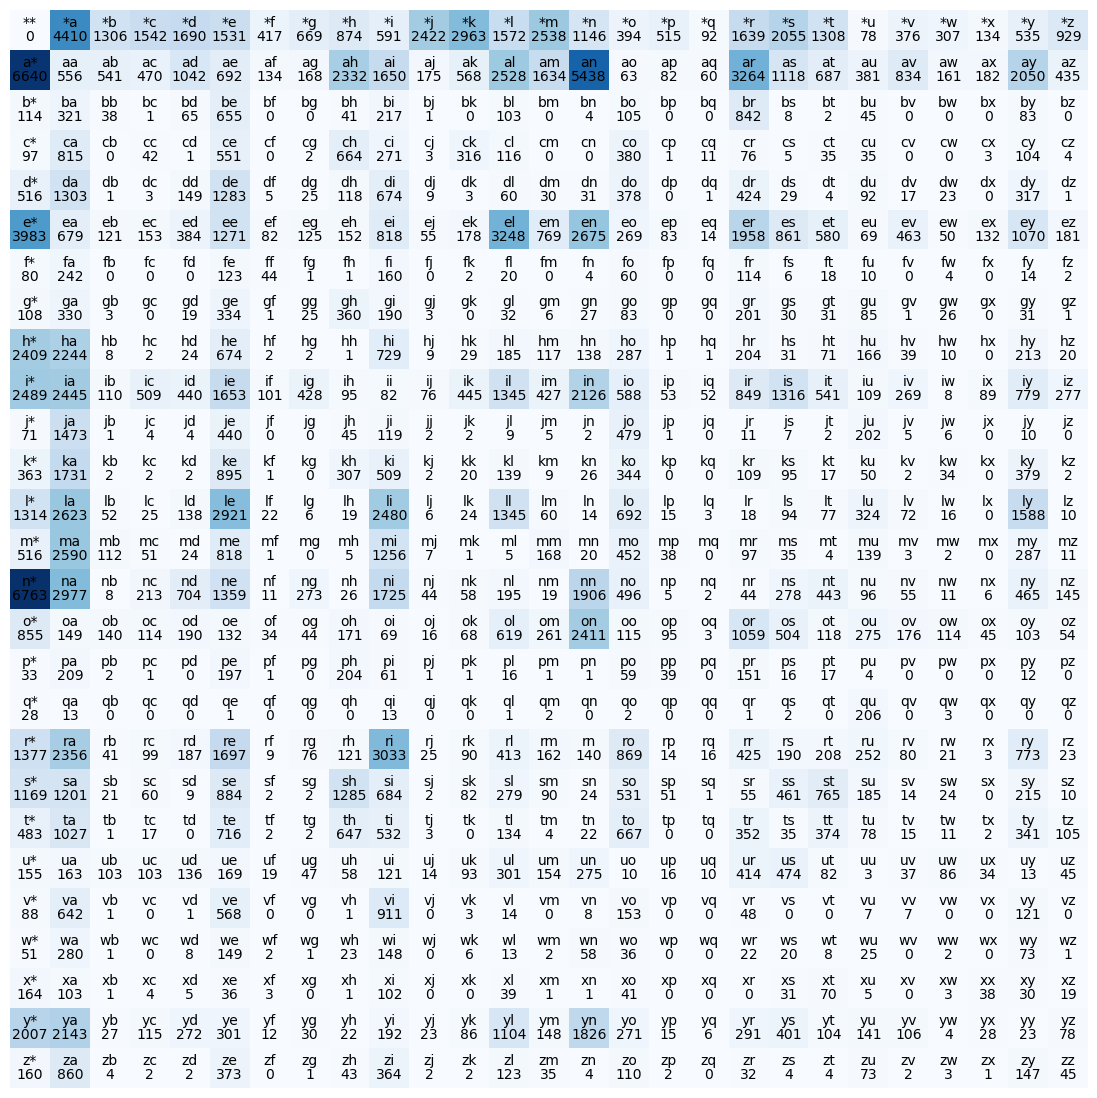

In [245]:
# plot the bigram occurances by sequence
plot_bigram_tensor(BIGRAMS)

In [246]:
# turn occurances into probabilities (iterative)
# create a zeros tensor with the same shape as `BIGRAMS`
# BIGRAMS_PROB = torch.zeros_like(BIGRAMS, dtype=torch.float)

# for row in range(BIGRAMS.shape[0]):
#     # divide each value of a row by the sum of that row
#     BIGRAMS_PROB[row] = BIGRAMS[row] / BIGRAMS[row].sum()
# BIGRAMS_PROB[0]

In [247]:
# turn occurances into probabilities (vectorized)

# get a copy of `BIGRAMS`
BIGRAMS_PROB = BIGRAMS.float()

# normalize values into probabilities
# right hand side is consistant with broadcasting semantics
BIGRAMS_PROB = BIGRAMS_PROB / BIGRAMS_PROB.sum(dim=1, keepdim=True)

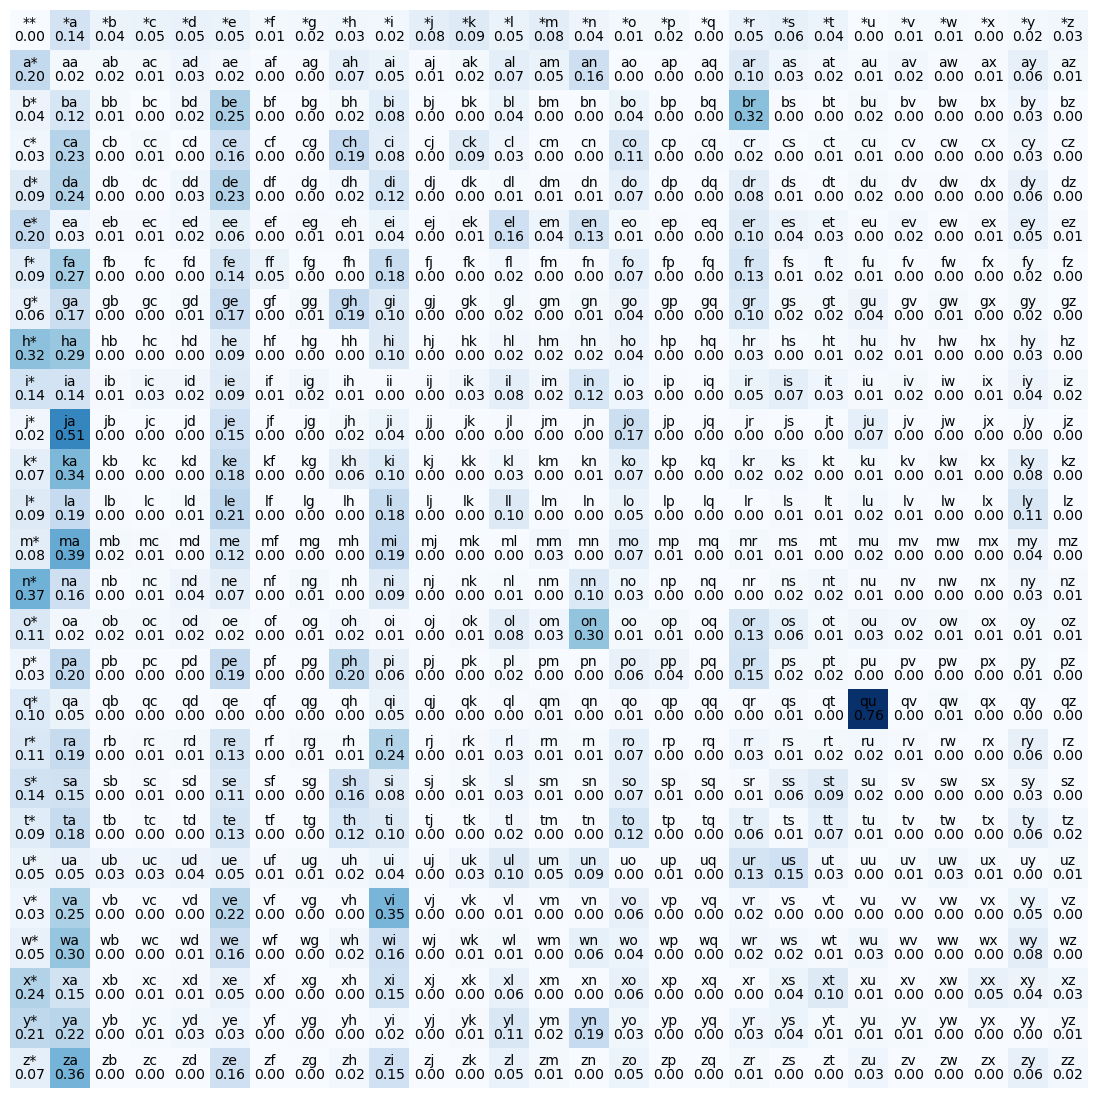

In [248]:
# plot bigram occurance probabilities
plot_bigram_tensor(BIGRAMS_PROB)

In [249]:
# function to generate names by sampling characters from the probability distribution
def generate_words(bg: torch.Tensor, n: int, generator: torch.Generator = None, return_words: bool = False):
    """
    Prints out `n` generated words from the given distribution `bg`.

    Parameters
    ----------
        - bg: Bigram Tensor
        - n: Number of desired words to generate
        - generator: A `torch.Generator` object for pseudo random behavior (optional)
        - return_words: Returns the generated words in a list if `True` (optional)
    """
    word_list = []  # list of words to return
    for i in range(n):
        word = ''
        i = 0  # index is 0 at first (itos[0] is '*')

        # generate until reached the end token
        while True:
            # this vector represents the probability of occurance of a character given `i` is the last character in the generated sequence
            p = bg[i]
            # choose the next character
            i = torch.multinomial(
                p, num_samples=1, replacement=True, generator=generator).item()
            # check if it has reached the end token
            if i == 0:
                break
            # add the next character to the sequence
            word += itos[i]

        if return_words:
            word_list.append(word)
        else:
            print(word)

    if return_words:
        return word_list

In [250]:
GEN = torch.manual_seed(SEED)
generate_words(BIGRAMS_PROB, 5, GEN)

anugeenvi
s
mabian
dan
stan


In [251]:
GEN = torch.manual_seed(SEED)
generate_words(BIGRAMS_PROB, 5, GEN, return_words=True)

['anugeenvi', 's', 'mabian', 'dan', 'stan']

In [257]:
# evaluating the model
def average_negative_log_likelihood_estimation(probs: torch.Tensor, data):
    log_likelihood = 0
    n = 0
    for word in data:
        word = list(br_tkn) + list(word) + list(br_tkn)
        for ch1, ch2 in zip(word, word[1]):
            prob = probs[stoi[ch1], stoi[ch2]]
            log_likelihood += torch.log(prob)
            n += 1
    neg_log_likelihood = -log_likelihood
    avg_neg_log_likelihood = neg_log_likelihood/n
    return avg_neg_log_likelihood.item()


def maximum_negative_log_likelihood_estimation(probs: torch.Tensor, data):
    max_neg_log_likelihood = 0
    for word in data:
        word = list(br_tkn) + list(word) + list(br_tkn)
        for ch1, ch2 in zip(word, word[1]):
            prob = probs[stoi[ch1], stoi[ch2]]
            neg_log_likelihood = -torch.log(prob)
            if neg_log_likelihood > max_neg_log_likelihood:
                max_neg_log_likelihood = neg_log_likelihood
    return max_neg_log_likelihood.item()

In [261]:
print(f'{average_negative_log_likelihood_estimation(BIGRAMS_PROB, names)=}')
print(f'{maximum_negative_log_likelihood_estimation(BIGRAMS_PROB, names)=}')

average_negative_log_likelihood_estimation(BIGRAMS_PROB, names)=2.9445555210113525
maximum_negative_log_likelihood_estimation(BIGRAMS_PROB, names)=6.017813205718994
